
## Logistic regression

Today's second exercise will involve classification using logistic regression with <a href="http://spark.apache.org/docs/latest/mllib-guide.html">MLlib</a>.

This exercise will be divided into four parts:
+ #### 1. Importing and preparing the data
+ #### 2. Logistic regression
+ #### 3. Evaluating the results

<br>
In the following exercises, you will need to replace the code parts in the cell that starts with following comment: "#Replace the `<INSERT>`"

To go through the notebook, fill in the `<INSERT>`:s with appropriate code in the cells. 
To run a cell, press Shift-Enter to run it and advance to the following cell or Ctrl-Enter to only run the code in the cell. You should do the exercises from the top to the bottom in this notebook, because following cells may depend on code in previous cells.

## Description of the data set
In this exercise, we will utilize the <a href="https://www.kaggle.com/c/stumbleupon">StumbleUpon Evergreen Classification Challenge</a> data set:

>StumbleUpon is a user-curated web content discovery engine that recommends relevant, high quality pages and media to its users, based on their interests. While some pages we recommend, such as news articles or seasonal recipes, are only relevant for a short period of time, others maintain a timeless quality and can be recommended to users long after they are discovered. In other words, pages can either be classified as "ephemeral" or "evergreen".

We will try to accurately predict a page as either "ephemeral" or "evergreen", i.e. having long lasting value to the users.

First we create a spark context:

In [1]:
# from pyspark import SparkContext, StorageLevel
# from pyspark.sql import SQLContext
# sc = SparkContext(master="local[*]")
# # sqlContext = SQLContext(sc)

In [2]:
#Helper functions to check results
import numpy as np

def check(x,y,label):
    if(x == y):
        print("Yay, "+label+" is correct!")
    else:
        print("Nay, "+label+" is incorrect, please try again!")

def checkArray(x,y,label):
    if np.allclose(x,y):
        print("Yay, "+label+" is correct!")
    else:
        print("Nay, "+label+" is incorrect, please try again!")

## 1. Importing and preparing the data

The data set is currently saved as a text file in the <a href="https://en.wikipedia.org/wiki/Tab-separated_values">tab separated values (TSV)</a> format, without a header, named "evergreen.tsv". We want to read in this textfile as separate lines into an rdd. A line is represented by the following fields, specified here: <a href="https://www.kaggle.com/c/stumbleupon/data">data specification</a>.

### 1.1 Creating the RDD
Read in the CSV-file as an RDD:

In [3]:
# Download train.tsv from the kaggle competition homepage for stumbleUpon Evergreen Classification Challenge
# The dataset used in the exercises does not contain the features' headers so we remove it
## use this if the train.csv dataset from the competition page on kaggle is used wuth
trainFh = open("train.tsv") # create a handle to the file
count = 0 
evergreenTsv = []
for line in trainFh:
    count += 1
    if count < 2:
        lineHdr = line
    else:
        evergreenTsv.append(line.strip())
print("Number of observations: " +str(count-1))

rawLines = sc.parallelize(evergreenTsv).cache()# if the train


Number of observations: 7395


In [4]:
# use this line for if the header is remove manually and the data set saved as evergreen.tsv
# the result might be different so many checks might not tally!
# rawLines = sc.textFile("evergreen.tsv").cache() #use if evergreen.tsv does not contain header

### 1.2 Checking out the RDD

Run the following code to get a feel for the data set:

In [5]:
numObs = rawLines.count()
sampleObs = rawLines.take(1)
sampleObs = sampleObs[0]
numFeatures = len(sampleObs.split('\t'))-1
print("The number of observations: "+str(numObs))
print("The number of features: "+str(numFeatures))
print("One observation: "+ str(sampleObs))
print(len(sampleObs))

The number of observations: 7395
The number of features: 26
One observation: "http://www.bloomberg.com/news/2010-12-23/ibm-predicts-holographic-calls-air-breathing-batteries-by-2015.html"	"4042"	"{""title"":""IBM Sees Holographic Calls Air Breathing Batteries ibm sees holographic calls, air-breathing batteries"",""body"":""A sign stands outside the International Business Machines Corp IBM Almaden Research Center campus in San Jose California Photographer Tony Avelar Bloomberg Buildings stand at the International Business Machines Corp IBM Almaden Research Center campus in the Santa Teresa Hills of San Jose California Photographer Tony Avelar Bloomberg By 2015 your mobile phone will project a 3 D image of anyone who calls and your laptop will be powered by kinetic energy At least that s what International Business Machines Corp sees in its crystal ball The predictions are part of an annual tradition for the Armonk New York based company which surveys its 3 000 researchers to find five i

In [6]:
#Check if the observations are correct
check(numObs, 7395, "the number of observations")
check(numFeatures, 26, "the number of features")
check(len(sampleObs), 6803, "the first observation")

Yay, the number of observations is correct!
Yay, the number of features is correct!
Yay, the first observation is correct!


### 1.2 Checking out the RDD some more
Features number 4, 5, 18, and 21 in the eighth observation got missing values represented by the string "?":

In [7]:
sampleObs = rawLines.take(8)[7]
print(sampleObs)
sampleObsVector = sampleObs.split('\t')
print("\nThe missing values from features 4, 5, 18, and 21: "+str([sampleObsVector [i] for i in [3,4,17,20]]))

"http://www.insidershealth.com/article/racing_for_recovery/3471"	"3402"	"{""url"":""insidershealth article racing for recovery 3471"",""title"":""Racing For Recovery by Dean Johnson racing for recovery by dean johnson - - insidershealth.com"",""body"":""Racing For Recovery is the growing idea that drug addiction and alcoholism can be cured by focusing one s energies towards something positive Eddie Freas tell CNN that I feel better when I m working out It does wonders for the mind The reason I started running it was a switch that went off in my head I started feeling positive and feeling great about myself It is true that dopamine levels can be increased by strenuous physical activity but is simply getting your fix in a healthy way actually healthy for you in the long run Freas admits to trying Alcoholics Anonymous and rehab but says the institutions did nothing to cure his drug addiction perhaps that is because of AA s non belief in the ability of a true addict to get cured they look 

Feature number 4 seems to be categorical:

In [8]:
feature4 = rawLines.map(lambda x:x.split("\t")[3].strip("\""))
print(feature4.take(2**5))

['business', 'recreation', 'health', 'health', 'sports', '?', 'arts_entertainment', '?', '?', '?', 'business', 'sports', 'health', '?', 'recreation', 'recreation', 'recreation', 'arts_entertainment', 'recreation', 'health', 'sports', 'recreation', 'health', '?', '?', 'sports', 'sports', 'business', '?', '?', 'recreation', 'recreation']


### 1.3 Parsing the vectors
This time we will wait with the creation of the LabeledPoints, because the data needs some preprocessing first. Firstly we will remove the three first features: the url of the page, the page ID, and the JSON representing the text of the page. 

The url may contain some information, i.e. pages with similar addresses, may have similar evergreen qualities, but will skip it for this exercise. The page ID should not contain any information, as it is only used for identifying the page, although it could contain some structure, e.g. if the distribution of evergreen pages is not uniform over time. The JSON-feature we will return to later in this exercise.

Implement the function below that parses the lines of the TSV-file and returns a list of unicode tokens corresponding to feature 4 to 27. You will remove the leading and trailing quotes (") using strip().

In [9]:
#Replace the <INSERT>
def parseObsVec(line):
    """Creates a vector of the 4 to 27 features, from a line in the input file.

    Args:
        line (str)): A line from the input TSV-file.

    Returns:
        vector: A unicode list of the 4 to 27 features, with the quotation marks removed.
    """
    wholeLine = line.split("\t")[3:]
    vector = [word.strip("\"") for word in wholeLine]
    return vector

In [10]:
parsedVec = rawLines.map(lambda x: parseObsVec(x))
exampleVec = parsedVec.take(1)[0]
print(exampleVec)

['business', '0.789131', '2.055555556', '0.676470588', '0.205882353', '0.047058824', '0.023529412', '0.443783175', '0', '0', '0.09077381', '0', '0.245831182', '0.003883495', '1', '1', '24', '0', '5424', '170', '8', '0.152941176', '0.079129575', '0']


In [11]:
#Check if the parsing function is correct
check(exampleVec, [u'business', u'0.789131', u'2.055555556', u'0.676470588', u'0.205882353', u'0.047058824', 
                   u'0.023529412', u'0.443783175', u'0', u'0', u'0.09077381', u'0', u'0.245831182', u'0.003883495',
                   u'1', u'1', u'24', u'0',u'5424', u'170', u'8', u'0.152941176', u'0.079129575', u'0'], 
      "the parsing function")

Yay, the parsing function is correct!


### 1.4 Creating a list of categories

To be able to map the categories to one-hot encoded (OHE) features, we will firstly need the list of the distinct categories. The category is the first element of the parsed vector parsedVec.

Create a list of the different categories from this first item in parsedVec:

In [12]:
#Replace the <INSERT>
#Extract the first element
parsedCat= parsedVec.map(lambda Obs: Obs[0])
#Collect all the distinct elements
listOfCat = sorted(parsedCat.distinct().collect()) # use sorted to guarantee fixed order for different starting dataset
print(listOfCat)

['?', 'arts_entertainment', 'business', 'computer_internet', 'culture_politics', 'gaming', 'health', 'law_crime', 'recreation', 'religion', 'science_technology', 'sports', 'unknown', 'weather']


In [13]:
#Check if the list of categories is correct
check(listOfCat, [u'?', u'arts_entertainment', u'business', u'computer_internet', u'culture_politics', u'gaming', 
                  u'health', u'law_crime', u'recreation', u'religion', u'science_technology', u'sports', 
                  u'unknown', u'weather'], 
      "the list of categories")

Yay, the list of categories is correct!


### 1.5 Creating a dictionary for the categories

After creating the list we need to create a dictionary mapping the categories to indices. 

As you may have noticed one category is "?", this could be imputed by replacing it with the most frequent category or the "unknown" category, but because it is a categorical feature we can use it as it is.

Create such a dictionary below:

In [14]:
OHEDict ={}
for i in range(0, len(listOfCat)):
    OHEDict[listOfCat[i]] = i
print(OHEDict)

{'?': 0, 'arts_entertainment': 1, 'business': 2, 'computer_internet': 3, 'culture_politics': 4, 'gaming': 5, 'health': 6, 'law_crime': 7, 'recreation': 8, 'religion': 9, 'science_technology': 10, 'sports': 11, 'unknown': 12, 'weather': 13}


In [15]:
#Check if the dictionary of categories is correct
check(OHEDict, {u'?': 0, u'arts_entertainment': 1, u'business': 2, u'computer_internet': 3, u'culture_politics': 4, 
                u'gaming': 5, u'health': 6, u'law_crime': 7, u'recreation': 8, u'religion': 9,
                u'science_technology': 10, u'sports': 11, u'unknown': 12, u'weather': 13}, 
      "the dictionary of categories")

Yay, the dictionary of categories is correct!


### 1.6 Extending the feature vector with one-hot encoded categories
We now need to create the OHE features, i.e. extending the feature vector with a vector consisting out of 13 zeros and 1 one.

Implement the following function that extends the feature vector with OHE encoded features. You will convert the category, which is the first element of rawVector and append it to end of rawVector.

In [16]:
#Replace the <INSERT>
def oneHotEncoding(rawVector, OHEDict):
    """Extends the feature vector with binary OHE features using a dictionary.

    Args:
        rawVector (list of str)): The features corresponding to a single observation.
        OHEDict (dict): A mapping of the categories to a unique integer.

    Returns:
        vector: A unicode list of the 5 to 27 features, extended with 14 binary OHE features.
    """
    Cat = rawVector[0]  # the category for this 0bservation
    CatInt = OHEDict[Cat] # the unique integer for the category
    catVector = np.zeros(len(OHEDict))
    catVector[CatInt] = 1
    rawVector.extend(catVector)
    vector = rawVector[1:]
    return vector

In [17]:
parsedOHE = parsedVec.map(lambda x:  oneHotEncoding(x,OHEDict))
sampleOHE = parsedOHE.take(1)[0]
print(sampleOHE)

['0.789131', '2.055555556', '0.676470588', '0.205882353', '0.047058824', '0.023529412', '0.443783175', '0', '0', '0.09077381', '0', '0.245831182', '0.003883495', '1', '1', '24', '0', '5424', '170', '8', '0.152941176', '0.079129575', '0', 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [18]:
#Check if the OHE features is correct
check(sampleOHE, [u'0.789131', u'2.055555556', u'0.676470588', u'0.205882353', u'0.047058824', u'0.023529412',
                  u'0.443783175', u'0', u'0', u'0.09077381', u'0', u'0.245831182', u'0.003883495',  u'1', 
                  u'1', u'24', u'0', u'5424', u'170', u'8', u'0.152941176', u'0.079129575', u'0', 0.0, 
                  0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
      "the OHE features")

Yay, the OHE features is correct!


### 1.7 Impute real valued feature
The first feature of the current feature vector is real valued, and has got missing values, represented by "?" as seen before. To be able to use the feature we need to somehow impute the missing values. One way of doing this is replacing the missing values with the mean of the non-missing values.

Implement the following function that takes the feature vector and replaces the "?" from the first feature in the vector with the mean:

In [19]:
#Replace the <INSERT>
def imputeMean(vector):
    """Imputes the missing values from the first feature with the mean

    Args:
        vector RDD(list of str): The features corresponding to a single observation.

    Returns:
        vector: A list with the 36 features, with the first feature imputed
    """
    meanVec = vector.map(lambda x: x[0]).filter(lambda x: x !="?")
    mean = meanVec.map(lambda x:  float(x)).mean()
    vector = vector.map(lambda x: x if x[0] != "?" else [mean]+x[1:])
    return vector

In [20]:
parsedMean = imputeMean(parsedOHE)
sampleMean = parsedMean.take(8)[7]
print(sampleMean)

[0.6033343166237874, '1.883333333', '0.71969697', '0.265151515', '0.113636364', '0.015151515', '0.49934811', '0', '0', '0.02661597', '0', '0.173745927', '0.025830258', '?', '0', '5', '?', '27656', '132', '4', '0.068181818', '0.148550725', '0', 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [21]:
#Check if the real value imputation is correct
check(sampleMean, [0.6033343166237874, u'1.883333333', u'0.71969697', u'0.265151515', u'0.113636364', u'0.015151515',
                   u'0.49934811', u'0', u'0', u'0.02661597', u'0', u'0.173745927', u'0.025830258', u'?', u'0', u'5', 
                   u'?', u'27656', u'132', u'4', u'0.068181818', u'0.148550725', u'0', 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
      "the mean imputation")

Yay, the mean imputation is correct!


### 1.8 Impute binary feature
The 14:th and 17:th features of the current feature vector are binary valued, and have got missing values, represented by "?" as seen before. To use these features, we need a method to impute the missing values.

One way of doing this is to replace the missing values with the mode of the non-missing values, i.e. the most frequent value. Utilize that the mode of a binary feature is its mean rounded to the nearest integer.

Implement the following function (that is very similar to the imputeMean function) that takes the feature vector and replaces the "?" from the feature with index, in the vector with the mode:

In [22]:
def imputeMode(vector,index):
    """Imputes the missing values from the feature with index, with the mode (for binary features)

    Args:
        vector (list of str): The features corresponding to a single observation.
        index (integer):

    Returns:
        vector: A list with the 36 features, with the index feature imputed
    """
    meanVec = vector.map(lambda x:  x[index]).filter(lambda x:  x != "?")
    mean = meanVec.map(lambda x:  float(x)).mean()
    mode = round(mean)
    vector = vector.map(lambda x: x if x[index] != "?" else x[0:index]+[mode]+x[index+1:])
    return vector

In [23]:
parsedMode1 = imputeMode(parsedMean,13)
parsedMode2 = imputeMode(parsedMode1,16)
sampleMode = parsedMode2.take(8)[7]
print(sampleMode)


[0.6033343166237874, '1.883333333', '0.71969697', '0.265151515', '0.113636364', '0.015151515', '0.49934811', '0', '0', '0.02661597', '0', '0.173745927', '0.025830258', 1, '0', '5', 0, '27656', '132', '4', '0.068181818', '0.148550725', '0', 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [24]:
#Check if the binary mode imputation is correct
check(sampleMode, [0.6033343166237874, '1.883333333', '0.71969697', '0.265151515', '0.113636364', '0.015151515',
                   '0.49934811', '0', '0', '0.02661597', '0', '0.173745927', '0.025830258', 1, '0', '5', 0,
                   '27656', '132', '4', '0.068181818', '0.148550725', '0', 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                   0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
      "the mode imputation")

Yay, the mode imputation is correct!


### 1.9 Remove the label from the vector
To scale and normalize the features, we need to remove the labels from the feature vectors. The label is the 23:th feature in the vector.

Create a list of the labels by removing them from the feature vectors:

In [25]:
labels = parsedMode2.map(lambda x: x[22])
features = parsedMode2.map(lambda x: x[0:22]+x[23:])
sampleLabel = labels.take(1)[0]
sampleFeatures = features.take(1)[0]
print(sampleLabel)
print(sampleFeatures)

0
['0.789131', '2.055555556', '0.676470588', '0.205882353', '0.047058824', '0.023529412', '0.443783175', '0', '0', '0.09077381', '0', '0.245831182', '0.003883495', '1', '1', '24', '0', '5424', '170', '8', '0.152941176', '0.079129575', 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [26]:
#Check if the labels and feature vectors are correct
check(sampleLabel, "0", "the labels")
check(sampleFeatures, ['0.789131', '2.055555556', '0.676470588', '0.205882353', '0.047058824', '0.023529412',
                       '0.443783175', '0', '0', '0.09077381', '0', '0.245831182', '0.003883495', '1', '1',
                       '24', '0', '5424', '170', '8', '0.152941176', '0.079129575', 0.0, 0.0, 1.0, 0.0,
                       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
      "the features")

Yay, the labels is correct!
Yay, the features is correct!


### 1.10 Scaling and normalizing the observations

In [27]:
#Importing some important stuff
from pyspark.mllib.feature import StandardScaler
from pyspark.mllib.feature import Normalizer
from pyspark.mllib.regression import LabeledPoint

In [28]:
def scaleNorm(features,labels):
    scaler = StandardScaler().fit(features)
    scaledFeatures = scaler.transform(features)
    norm = Normalizer()
    normScaledFeatures = norm.transform(scaledFeatures)
    normScaledObs = labels.zip(normScaledFeatures)
    normScaledObs = normScaledObs.map(lambda x: LabeledPoint(x[0], x[1]))
    return normScaledObs

In [29]:
normScaledObs = scaleNorm(features,labels)
sampleNormScaled = normScaledObs.take(1)[0]
print(sampleNormScaled)

(0.0,[0.48708235162803837,0.025898795833360848,0.3616719228137091,0.1523735630461378,0.053249505453644,0.035184367749224184,0.008449181770097007,0.0,0.0,0.2378640938613115,0.0,0.5086698478590467,0.0002197467961820353,0.0,0.22929933903438884,0.1278130347573795,0.0,0.0663708422856169,0.10287584823955488,0.268730211618676,0.09062397386809554,0.10846547068583773,0.0,0.0,0.33539565835673985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])


In [30]:
checkArray(sampleNormScaled.features, [0.48708235162803837,0.025898795833360848,0.3616719228137091,0.1523735630461378,
                                       0.053249505453644,0.035184367749224184,0.008449181770097007,0.0,0.0,
                                       0.23786409386131144,0.0,0.5086698478590467,0.0002197467961820353,0.0,
                                       0.22929933903438884,0.1278130347573795,0.0,0.06637084228561693,0.10287584823955488,
                                       0.268730211618676,0.09062397386809554,0.10846547068583773,0.0,0.0,
                                       0.33539565835673985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], 
      "the normalized and scaled features")

Yay, the normalized and scaled features is correct!


### 1.11 Illustrating the features
We will visualize the data set, by projecting it from 36 dimensions to 2. This dimensionality reduction is achieved by using <a href="https://en.wikipedia.org/wiki/Principal_component_analysis">PCA</a>:

In [31]:
from sklearn.decomposition import TruncatedSVD
import numpy as np
#convert features to float data type us numpy
features = features.map(lambda x: np.array(x).astype(np.float64))
#Calculate the PCA of normScaledFeatures
Y = TruncatedSVD(n_components=2).fit_transform(features.collect())

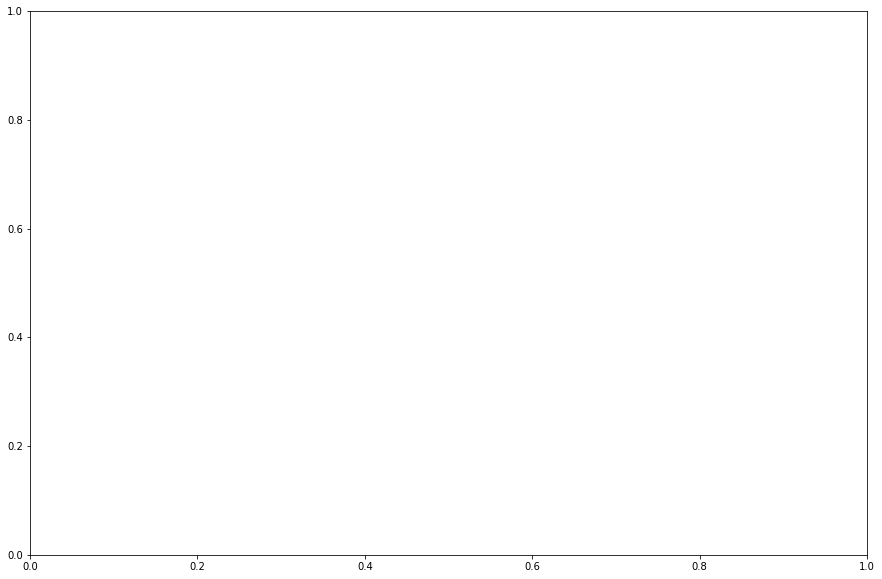

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
ax = plt.gca()

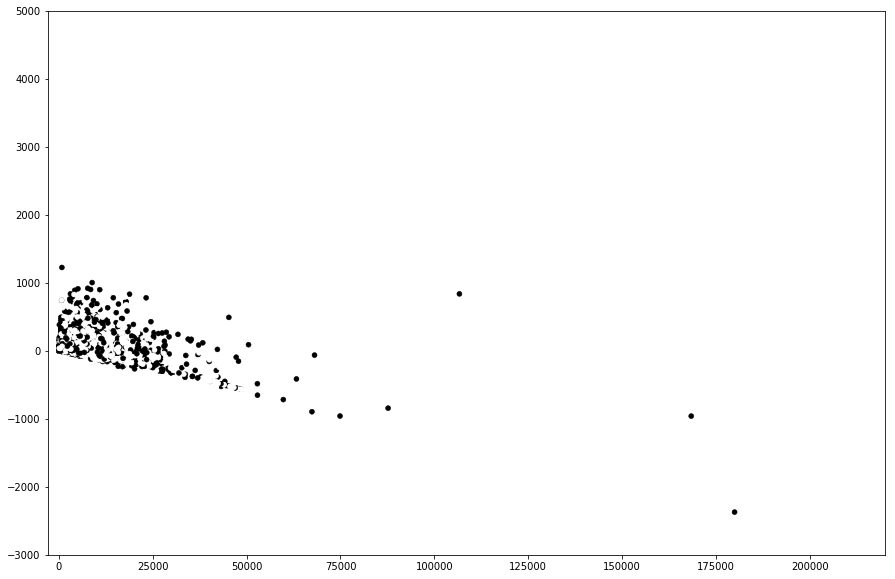

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
axes = plt.gca()
axes.set_xlim([-3000,220000])
axes.set_ylim([-3000,5000])
plt.scatter(Y[:, 0], Y[:, 1], c=labels.collect(),linewidths=.5, s=25)

Let us zoom in on the large cluster of points:

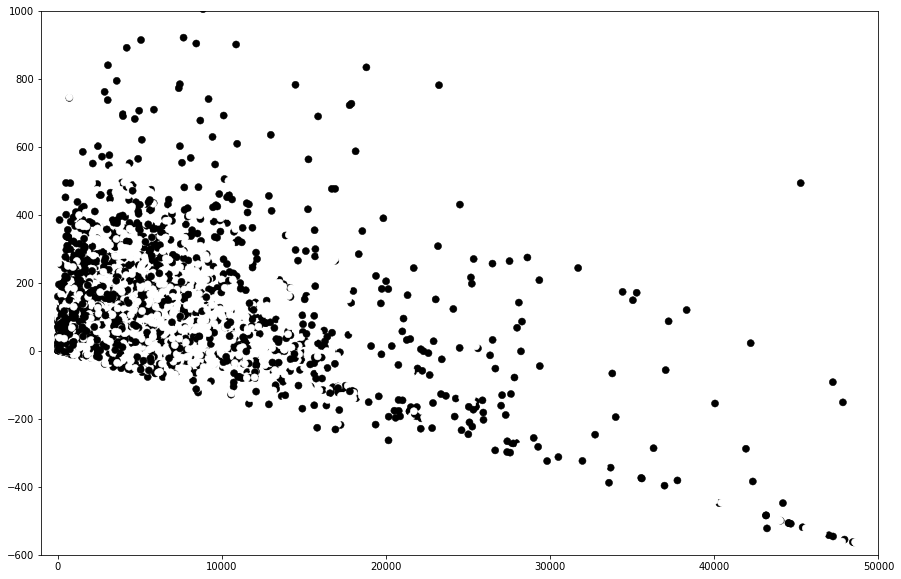

In [34]:
plt.figure(figsize=(15,10))
axes = plt.gca()
axes.set_xlim([-1000,50000])
axes.set_ylim([-600,1000])
plt.scatter(Y[:, 0], Y[:, 1], c=labels.collect(),linewidths=.5, s=50)

### 1.12  Splitting the data into training, validation, and test sets 
Our last task with preparing the data set is to split it into a training, validation and test set. An usual split is 70%/15%/15%:

In [35]:
weights = [.7, .15, .15]
seed = 0
trainObsNum, valObsNum, testObsNum = normScaledObs.randomSplit(weights, seed)

trainObsNum.cache()
valObsNum.cache()
testObsNum.cache()

PythonRDD[38] at RDD at PythonRDD.scala:52

In [36]:
numTrain = trainObsNum.count()
numVal = valObsNum.count()
numTest = testObsNum.count()

print("Size of train set: "+str(numTrain))
print("Size of validation set: "+str(numVal))
print("Size of test set: "+str(numTest))
print("Size of total data set: "+str(+numTrain+numVal+numTest))

Size of train set: 5156
Size of validation set: 1108
Size of test set: 1131
Size of total data set: 7395


In [37]:
#Check if the data sets are correct
check(numTrain, 5156, "the train set")
check(numVal, 1108, "the validation set")
check(numTest, 1131, "the test set")
check(numTrain+numVal+numTest, 7395, "the total data set")

Yay, the train set is correct!
Yay, the validation set is correct!
Yay, the test set is correct!
Yay, the total data set is correct!


## 2. Logistic regression

### 2.1 Logistic regression with limited-memory BFGS
MLlib's <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionWithLBFGS">LogisticRegressionWithLBFGS</a> utilizes logistic regression with <a href="https://en.wikipedia.org/wiki/Limited-memory_BFGS">limited-memory Broyden–Fletcher–Goldfarb–Shanno</a> as an optimization algorithm. There exists a SGD variant of logistic regression in MLlib also, but the LBFGS tends to be both faster and use less memory.

Create the following logistic regression model with the regParam option set to regPar and the rest the default values:

In [38]:
#Import even more important stuff
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

In [39]:
#Replace the <INSERT>
regPar = 0.00001
modelNum = LogisticRegressionWithLBFGS().train(trainObsNum, regParam=regPar)
weights = modelNum.weights
print(weights)

[-0.5792246616026886,-0.7720054719806997,1.3340271420107594,-0.6641228782788721,2.9933425927019996,-1.1200057148952272,0.1560571831733771,0.1864696983541056,0.0,-2.6548244075634972,-0.10664216815805475,0.4881894663120436,-1.0732481949761863,0.0,0.3133400515534091,-3.977033455631937,-0.6283775178048432,-1.1349388530143092,1.6207148215766516,-0.4494454507516087,0.3146856868733079,-1.2301270034568885,3.0392485860660283,0.645662135046921,4.3084946371126005,-0.8101758587448324,1.0488978099735624,0.3540892160166938,1.8377624653539297,0.2220449211950997,4.562835235095612,-0.11430132763476068,0.8197813347186519,-1.1308182226056105,0.4085969143359474,-7.763022999026221]


In [40]:
#Check if the model is correct
checkArray(weights, [-0.5792246615548065,-0.7720054719556295,1.3340271419052456,-0.6641228782076674,2.9933425926668265,
                     -1.1200057149128082,0.15605718323893583,0.18646969847394024,0.0,-2.654824407616171,
                     -0.10664216815030625,0.48818946633109445,-1.0732481951284933,0.0,0.31334005165610423,
                     -3.9770334555966103,-0.6283775177452231,-1.1349388530297533,1.6207148214878535,-0.44944545074860837,
                     0.3146856869187459,-1.2301270033932048,3.039248585975991,0.6456621349767238,4.3084946369275,
                     -0.8101758587721467,1.0488978099107702,0.35408921600228527,1.8377624652557274,0.2220449211833375,
                     4.562835234985785,-0.11430132761363056,0.8197813346728,-1.1308182225633865,0.40859691434735396,
                     -7.76302299944107], 
      "weights of the model")

Yay, weights of the model is correct!


### 2.2 Evaluating the logistic regression

A common metric to evaluate binary classification is the <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve">area under the receiver operating characteristic (AUROC)</a>, which is also used as the evaluation metric by <a href="https://www.kaggle.com/c/stumbleupon/details/evaluation">StumbleUpon Evergreen Classification Challenge</a>. A model that assigns random labels to observations will get an AUROC of 0.5, so hopefully we will beat that! ;)

You do not need to calculate this yourself, use instead the following MLlib class: <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.evaluation.BinaryClassificationMetrics">BinaryClassificationMetrics</a>. To get the raw percentages from the predict method, you need to use <a href="https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.classification.LogisticRegressionModel.clearThreshold">clearThreshold()</a> instead of the binary classification.

An alternative is to use the roc_auc_score method from sklearn metrics library: <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html">AUROC score</a>.

Calculate the AUROC for the validation data:

In [41]:
#from pyspark.mllib.evaluation import BinaryClassificationMetrics #not working for me in windows pyspark
from sklearn.metrics import roc_auc_score

In [42]:
# We write a function to calculate the AUROC using the sklearn metrics library

def ROC(predLabel):
    """Calculate the area under the receiver operating curves (AUROC)

    Args:
        predLabel: RDD vector of prediction and corresponding label tuple .

    Returns:
        ROC: A scalar of the calculated ROC value
    """
    predAndLabel= predLabel.collect()
    y_pred = []
    y_true = []
    for comb in predAndLabel:
        y_pred.append(comb[0])
        y_true.append(comb[1])
    return roc_auc_score(np.array(y_true), np.array(y_pred))

In [43]:
modelNum.clearThreshold()
predLabel = valObsNum.map(lambda lp:(modelNum.predict(lp.features), lp.label))
AUROC = ROC(predLabel)
print(AUROC)

0.7452004420581131


In [44]:
#Check if the AUROC on the validation set is correct
check(round(AUROC,3), 0.745, "AUROC of the validation set")

Yay, AUROC of the validation set is correct!


## 3. Evaluating the results

### 3.1 Evaluate the model on the test set
Let us try out the model on the test set, and see how they fare:

In [45]:
predLabel = testObsNum.map(lambda lp:(modelNum.predict(lp.features), lp.label))
AUROC = ROC(predLabel)
print(AUROC)

0.7400714343798283


In [46]:
#Check if the numeric model's AUROC on the test set is correct
check(round(AUROC,3), 0.740, "AUROC of the validation set")

Yay, AUROC of the validation set is correct!


### 3.2 Post mortem discussion
If you check <a href="https://www.kaggle.com/c/stumbleupon/leaderboard">the leaderboard</a> on Kaggle, you can see that the winner had an AUROC of 0.88906, although not directly comparable with our result on the test set, because they used another test set, but still it gives an indication of the quality of the result.

A lower bound should be an AUROC of 0.5, because a model that assigns random labels to observations will get it, although 10 participants in the Kaggle challenge did not get better than that.

If we would have gotten the same result on their test set, i.e. 0.710 we would have placed on the 540:th place out of 625 participants. We would not have beaten Random Forest Benchmark 0.768, in which they applied random forest to the provided features.

But you will improve on this result in this week home assignment, by using the JSON-feature!